In [3]:
# Standard Libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Utilities
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from scipy import stats

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras import layers, models, initializers, backend as K
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import (
    to_categorical,
    get_custom_objects,
    register_keras_serializable
)
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [5]:
@register_keras_serializable()
def squash(vectors, axis=-1):
    """
    Applies the squash function to input vectors.
    The squash function ensures that the magnitude of each vector lies between 0 and 1,
    while preserving its direction. This is a critical part of the Capsule Networks
    to ensure that the output vectors are normalized.
    """

    # Step 1: Compute the squared L2 norm of the vectors along the specified axis.
    # This calculates the sum of the squares of the vector components.
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)

    # Step 2: Calculate the scaling factor for the squash function.
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm)

    # Step 3: Scale the input vectors by the computed scale factor.
    # This operation modifies the magnitude of the vectors while preserving their direction.
    return scale * vectors

In [7]:
@register_keras_serializable()
def PrimaryCap2D(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    """
    Creates a Primary Capsule layer in 2D using convolution and reshaping.
    This layer is typically the first capsule layer in a Capsule Network.

    Parameters:
        inputs (Tensor): Input tensor, usually the output of a feature extraction layer.
        dim_capsule (int): The dimensionality of each capsule vector.
        n_channels (int): The number of capsule channels.
        kernel_size (int): The size of the convolution kernel.
        strides (int): The stride of the convolution.
        padding (str): Padding type for convolution.
    """

    # Step 1: Apply a 2D convolution to the input tensor.
    # This extracts features and prepares them for grouping into capsules.
    output = layers.Conv2D(
        filters=dim_capsule * n_channels,
        kernel_size=kernel_size,
        strides=strides,
        kernel_initializer='he_normal',
        padding=padding,
        name='primarycap_conv2d'
    )(inputs)

    # Step 2: Reshape the convolution output into a tensor of capsules.
    # The target shape is (-1, dim_capsule), where:
    # - `-1` lets TensorFlow automatically calculate the appropriate size for the batch dimension.
    # - `dim_capsule` represents the dimensionality of each capsule vector.
    outputs = layers.Reshape(
        target_shape=[-1, dim_capsule],
        name='primarycap_reshape'
    )(output)

    # Step 3: Apply the squash function to normalize the capsule vectors.
    return layers.Lambda(squash, name='primarycap_squash')(outputs)

In [9]:
@register_keras_serializable()
class CapsuleLayer(layers.Layer):
    """
    A Capsule Layer that implements dynamic routing between capsules.

    Parameters:
        num_capsule (int): Number of capsules in the output layer.
        dim_capsule (int): Dimensionality of each output capsule vector.
        routings (int): Number of routing iterations.
        kernel_initializer (str): Initializer for the weight matrix.
        **kwargs: Additional keyword arguments for the parent Layer class.
    """

    def __init__(self, num_capsule, dim_capsule, routings, kernel_initializer='glorot_uniform', **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        """
        Build the layer's weight matrix based on the input shape.

        Parameters:
            input_shape (tuple): Shape of the input tensor (batch_size, input_num_capsule, input_dim_capsule).
        """

        # Number of input capsules and their dimensions
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Weight matrix W for transformation between input and output capsules
        # Shape: [num_capsule, input_num_capsule, dim_capsule, input_dim_capsule]
        self.W = self.add_weight(
            shape=[self.num_capsule, self.input_num_capsule, self.dim_capsule, self.input_dim_capsule],
            initializer=self.kernel_initializer,
            name='W'
        )

        # Mark the layer as built
        self.built = True

    def call(self, inputs, training=None):
        """
        Perform the forward pass with dynamic routing.

        Parameters:
            inputs (Tensor): Input tensor of shape (batch_size, input_num_capsule, input_dim_capsule).
            training (bool): Training mode indicator (default is None).
        """

        inputs = tf.ensure_shape(inputs, [1, 512, 8])

        # Expand dimensions to prepare for tiling
        # Shape after expansion: [batch_size, 1, input_num_capsule, input_dim_capsule, 1]
        inputs_expand = tf.expand_dims(tf.expand_dims(inputs, 1), -1)

        # Tile the inputs to match the number of output capsules
        # Shape after tiling: [batch_size, num_capsule, input_num_capsule, input_dim_capsule, 1]
        inputs_tiled = tf.tile(inputs_expand, [1, self.num_capsule, 1, 1, 1])

        # Perform the transformation using the weight matrix W
        # Shape after transformation: [batch_size, num_capsule, input_num_capsule, dim_capsule]
        inputs_hat = tf.squeeze(
            tf.map_fn(lambda x: tf.matmul(self.W, x), elems=inputs_tiled)
        )

        # Initialize the coupling coefficients
        # Shape: [batch_size, num_capsule, 1, input_num_capsule]
        b = tf.zeros(shape=[tf.shape(inputs)[0], self.num_capsule, 1, self.input_num_capsule])

        # Routing algorithm
        for i in range(self.routings):
            # Compute softmax over coupling coefficients
            # Shape: [batch_size, num_capsule, 1, input_num_capsule]
            c = tf.nn.softmax(b, axis=1)

            # Weighted sum of input predictions
            # Shape: [batch_size, num_capsule, 1, dim_capsule]
            outputs = squash(tf.matmul(c, inputs_hat))

            # Update coupling coefficients based on agreement
            if i < self.routings - 1:
                # Update b for the next iteration
                b += tf.matmul(outputs, inputs_hat, transpose_b=True)

        # Return the output capsules, squeezed to remove unnecessary dimensions
        return tf.squeeze(outputs)

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

In [11]:
@register_keras_serializable()
class Length(layers.Layer):
    """
    Compute the length (Euclidean norm) of vectors in a tensor.

    Use case:
    - Interpret vector lengths as probabilities for multi-class predictions.

    Inputs:
        - shape: [batch size, num vectors, dim vector]

    Outputs:
        - shape: [batch size, num vectors]
    """

    def call(self, inputs, **kwargs):
        """
        Forward pass of the layer.

        Parameters:
            inputs (tensor): A tensor of shape [batch size, num vectors, dim vector].
        """
        # Compute the Euclidean norm (length) of vectors
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(Length, self).get_config()
        return config

In [13]:
@register_keras_serializable()
class Mask(layers.Layer):
    """
    Mask Layer for Capsule Networks.

    Masks capsule outputs based on:
    1. Provided true labels (supervised).
    2. Capsule with maximum length (unsupervised).
    """
    def call(self, inputs, **kwargs):
        # use true label to select target capsule, shape=[batch_size, num_capsule]
        if type(inputs) is list:  # true label is provided with shape = [batch_size, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of vectors of capsules
            x = inputs
            # Enlarge the range of values in x to make max(new_x)=1 and others < 0
            x = (x - K.max(x, 1, True)) / K.epsilon() + 1
            mask = K.clip(x, 0, 1)  # the max value in x clipped to 1 and other to 0

        # masked inputs, shape = [batch_size, dim_vector]
        inputs_masked = K.batch_dot(inputs, mask, [1, 1])
        return inputs_masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][-1]])
        else:
            return tuple([None, input_shape[-1]])

In [15]:
@register_keras_serializable()
def margin_loss(y_true, y_pred):
    """
    Computes the margin loss.

    Parameters:
        y_true: Tensor of shape [batch_size, n_classes], one-hot encoded true labels.
        y_pred: Tensor of shape [batch_size, n_classes], predicted probabilities (length of capsules).

    Returns:
        A scalar loss value computed across the batch.
    """
    # Calculate the loss for positive classes (y_true == 1)
    # Encourages the predicted probability to be close to 0.9
    positive_loss = y_true * tf.square(tf.maximum(0., 0.9 - y_pred))

    # Calculate the loss for negative classes (y_true == 0)
    # Encourages the predicted probability to be close to 0.1
    negative_loss = 0.5 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - 0.1))

    # Combine the positive and negative losses
    L = positive_loss + negative_loss

    # Compute the total loss as the sum of losses across all classes for each sample,
    # followed by the mean across the batch
    return tf.reduce_mean(tf.reduce_sum(L, axis=1))

In [17]:
# Define your custom activation function if needed (in this case, LeakyReLU)
def custom_activation_function(identifier):
    if identifier == 'LeakyReLU':
        return LeakyReLU

# Ensure your custom layers are available during loading
get_custom_objects().update({
    'CapsuleLayer': CapsuleLayer,
    'PrimaryCap2D': PrimaryCap2D,
    'Length': Length,
    'Mask': Mask,
    'squash': squash,
    'LeakyReLU': custom_activation_function,
    'margin_loss': margin_loss
})

# Load the model with custom layers
model = load_model(r'capsnet_emnist_full_model_save.keras', custom_objects=get_custom_objects())

# Verify by printing the summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (64, 28, 28, 1)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_layer (Conv2D)          │ (64, 24, 24, 32)          │             832 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_layer (Conv2D)          │ (64, 20, 20, 32)          │          25,632 │ conv1_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3_layer (Conv2D)          │ (64, 16, 16, 128)         │         102,528 │ conv2_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv4_layer (Conv2D)          │ (64, 14, 14, 128)         │         147,584 │ conv3_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv5_layer (Conv2D)          │ (64, 12, 12, 256)         │         295,168 │ conv4_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ primarycap_conv2d (Conv2D)    │ (64, 4, 4, 256)           │       1,638,656 │ conv5_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ primarycap_reshape (Reshape)  │ (64, 512, 8)              │               0 │ primarycap_conv2d[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ primarycap_squash (Lambda)    │ (64, 512, 8)              │               0 │ primarycap_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ digit_capsule_layer           │ (None, 62, 16)            │       4,063,232 │ primarycap_squash[0][0]    │
│ (CapsuleLayer)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ label_input (InputLayer)      │ (None, 62)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ mask (Mask)                   │ (None, 16)                │               0 │ digit_capsule_layer[0][0], │
│                               │                           │                 │ label_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 512)               │           8,704 │ mask[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1024)              │         525,312 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 784)               │         803,600 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ capsnet (Length)              │ (None, 62)                │               0 │ digit_capsule_layer[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 22,833,746 (87.10 MB)

 Trainable params: 7,611,248 (29.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,222,498 (58.07 MB)

In [19]:
def preprocess_emnist_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    img = cv2.bitwise_not(img)

    h, w = img.shape
    if h > w:
        pad = (h - w) // 2
        img = cv2.copyMakeBorder(img, 0, 0, pad, pad, cv2.BORDER_CONSTANT, value=0)
    elif w > h:
        pad = (w - h) // 2
        img = cv2.copyMakeBorder(img, pad, pad, 0, 0, cv2.BORDER_CONSTANT, value=0)

    img = cv2.resize(img, (28, 28), interpolation=cv2.INTER_AREA)

    img = img.astype(np.float32) / 255.0

    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)

    # Display the processed image
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title("EMNIST-Compatible Processed Image")
    plt.axis('off')
    plt.show()

    return img

# Predict function using your EMNIST-style preprocessing
def predict_letter(model, image_path, class_labels):
    img = preprocess_emnist_image(image_path)  # Preprocess image
    y_pred = model.predict(img)                # Model prediction

    predicted_class = np.argmax(y_pred)        # Get class index
    predicted_label = class_labels[predicted_class]  # Map to label

    return predicted_label

# Building evaluation model from the 'capsnet' output
image_input = model.input[0]
caps_output = model.get_layer('capsnet').output  # Make sure this layer exists
eval_model = Model(inputs=image_input, outputs=caps_output)

# Class labels (same used during training)
class_labels = list("0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz")

In [23]:
import os
import time
import tkinter as tk
from PIL import Image, ImageGrab, ImageTk, ImageOps, ImageDraw, ImageFont
import cv2
import numpy as np
import matplotlib.pyplot as plt
from spellchecker import SpellChecker
import re
import spacy

All captures will be saved to: D:\Studies Material\OLA Project\handwritten_captures


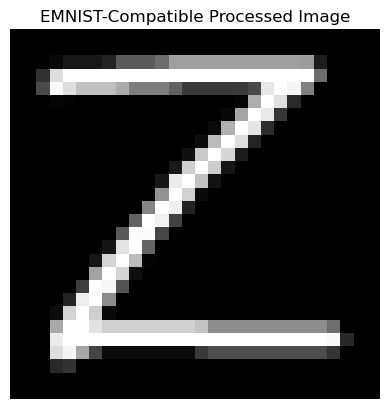

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


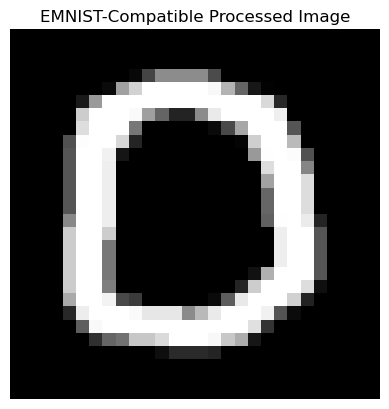

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


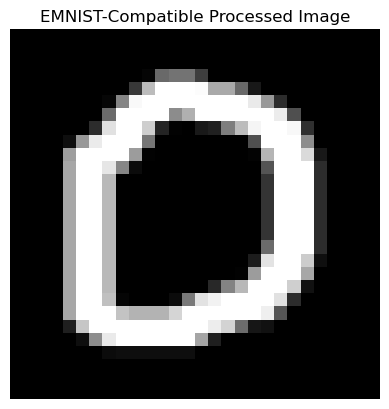

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


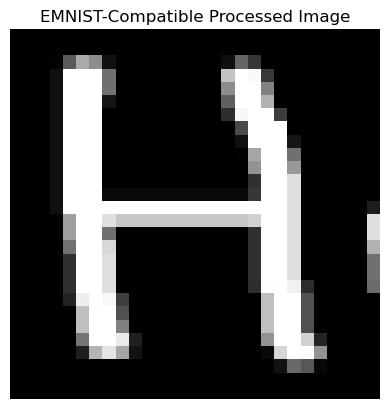

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


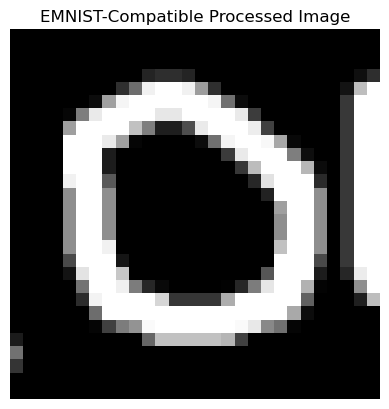

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


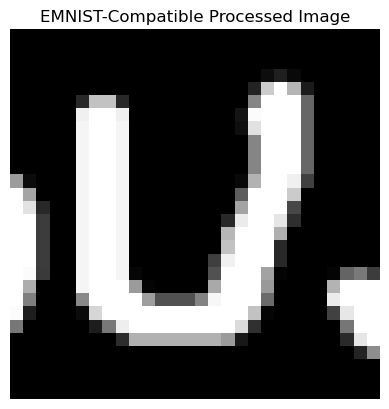

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


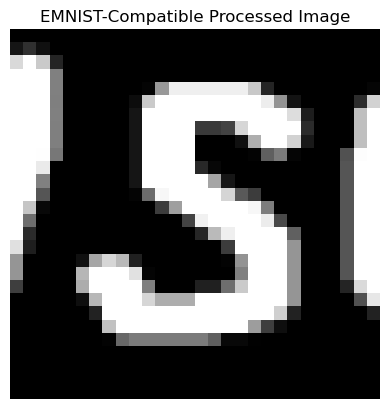

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


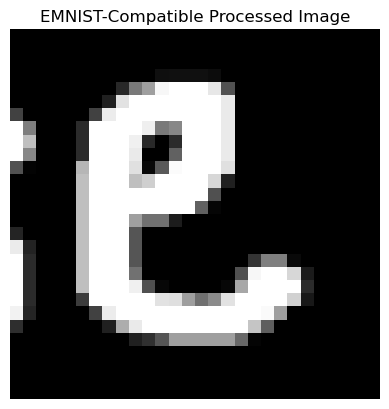

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Text: ZOOHOUSC
Corrected Text with spell checker and Rules apply Confusing Pairs: Zoohousc
Corrected Text with Acrononyms correct text: ZOOHOUSC


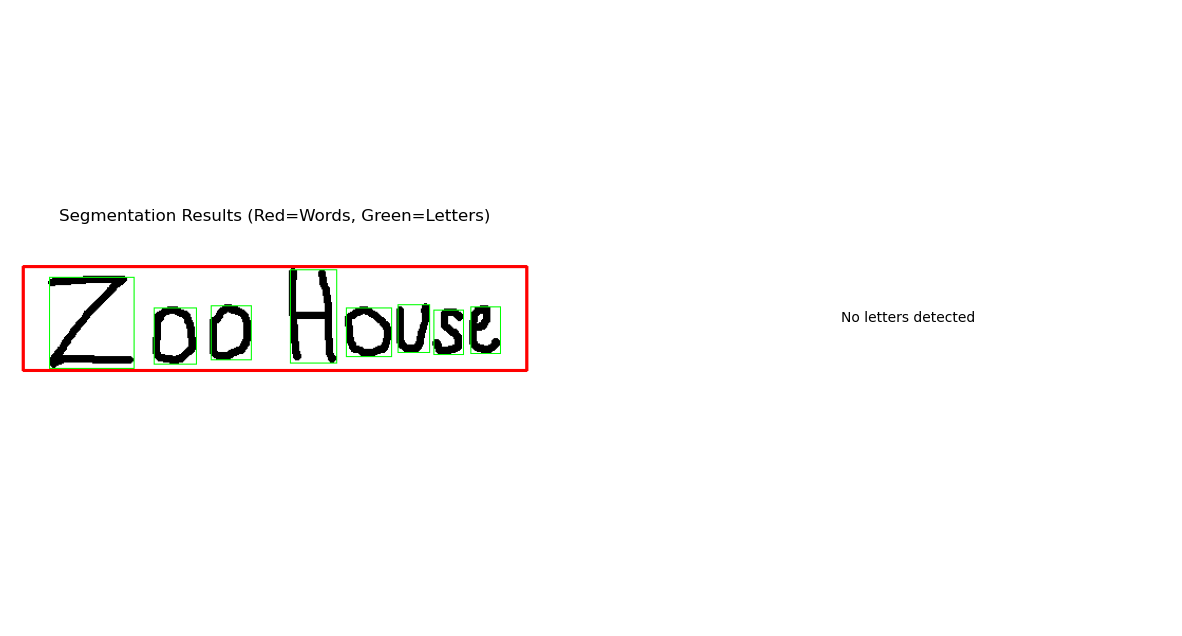

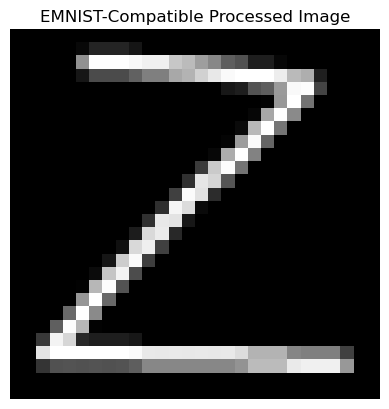

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


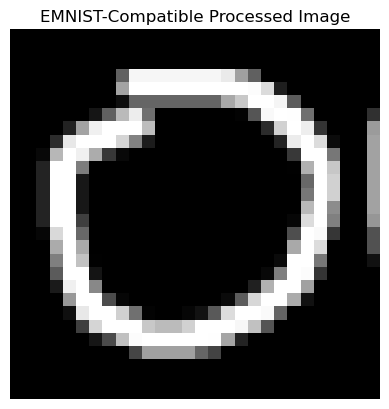

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


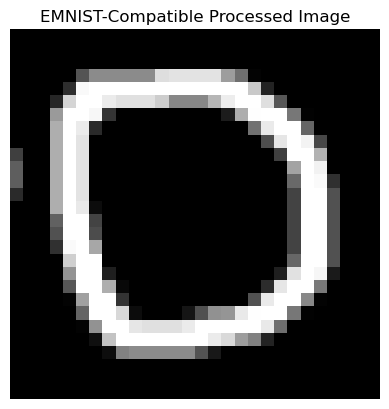

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


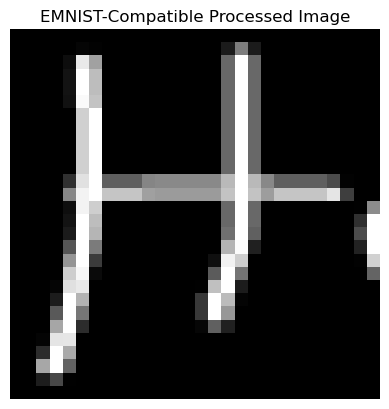

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


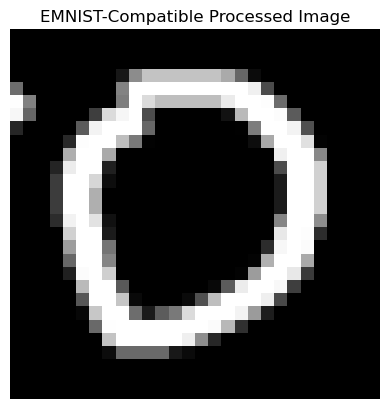

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


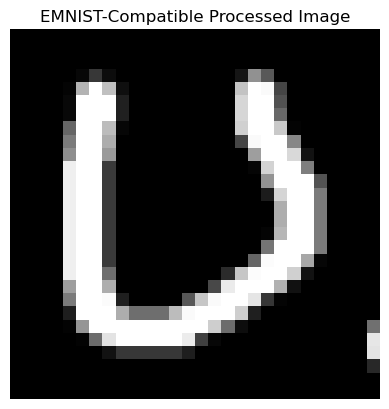

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


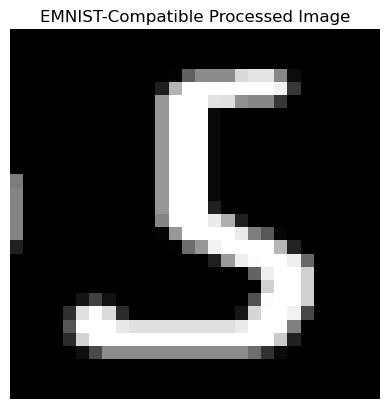

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


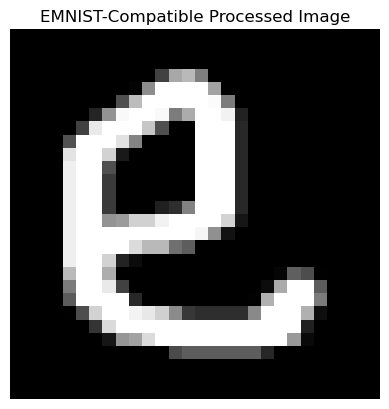

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Text: ZOO HOUSC
Corrected Text with spell checker and Rules apply Confusing Pairs: Zoo House
Corrected Text with Acrononyms correct text: Zoo House


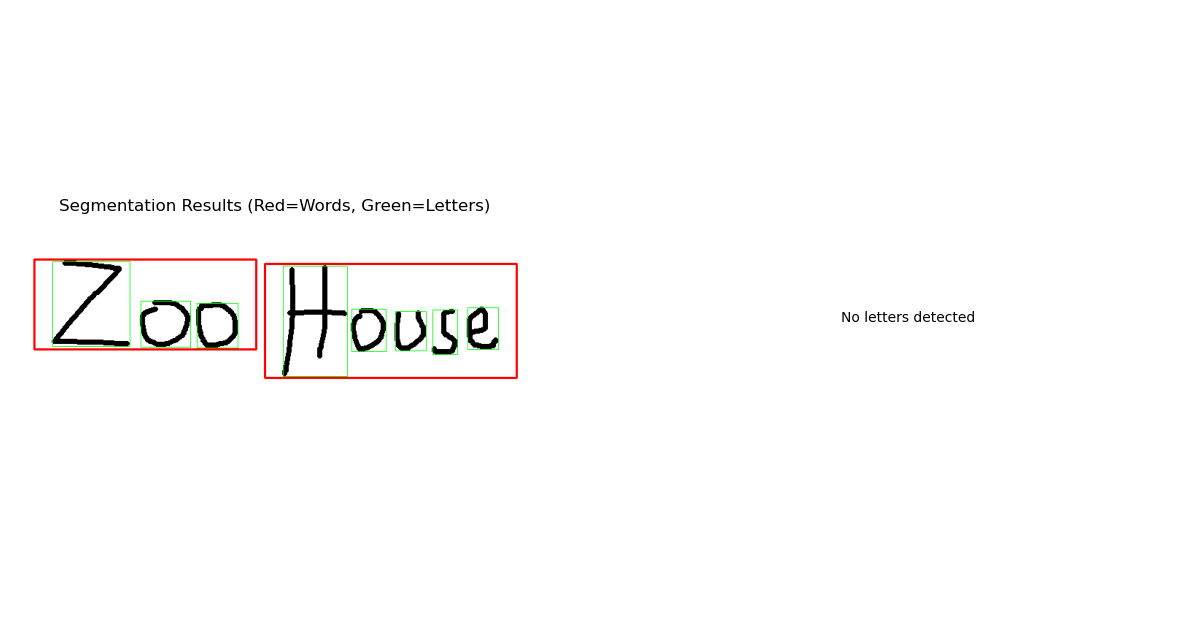

In [27]:
# Fix DPI scaling issue
try:
    from ctypes import windll
    windll.shcore.SetProcessDpiAwareness(1)
except:
    pass

# Set paths
DESKTOP_PATH = r"D:\Studies Material\OLA Project"
HANDWRITTEN_IMAGE_DIR = os.path.join(DESKTOP_PATH, "handwritten_captures")
os.makedirs(HANDWRITTEN_IMAGE_DIR, exist_ok=True)

# Initialize Tkinter canvas
root = tk.Tk()
root.title("Real-Time Handwriting Segmentation & Replacement")
canvas_width, canvas_height = 1200, 800
canvas = tk.Canvas(root, width=canvas_width, height=canvas_height, bg="white")
canvas.pack()

# Global variables
last_x, last_y = None, None
drawing = False
min_x, min_y, max_x, max_y = canvas_width, canvas_height, 0, 0
capture_timer = None
captured = False
current_capture_path = None
letter_images = []  
bounding_boxes = []
image_references = []
padding = 10

# Load NLP model
nlp = spacy.load("en_core_web_sm")

# Text correction functions
def correct_text_with_specific_rules(input_text):
    spell = SpellChecker()
    non_cap_letters = {'a','b','c','d', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l','m','n','o','p','q','r','s','t','u','v','w','x','y','z'}
    
    words = re.findall(r"\w+|\W+", input_text)
    corrected_words = []

    for word in words:
        if not word.strip() or not word.isalpha():
            corrected_words.append(word)
            continue

        corrected_word = spell.correction(word.lower()) or word.lower()

        new_word = []
        for i, char in enumerate(corrected_word):
            if i == 0:
                new_word.append(word[0] if i < len(word) else char)
            else:
                if char.lower() in non_cap_letters:
                    new_word.append(char.lower())
                else:
                    original_char = word[i] if i < len(word) else char
                    new_word.append(original_char if original_char.isupper() else char.lower())

        corrected_words.append(''.join(new_word))
    
    return ''.join(corrected_words)

def detect_and_format_acronyms(text):
    doc = nlp(text)
    updated_text = text
    for ent in doc.ents:
        if ent.label_ in ["ORG", "GPE", "NORP"]:
            if not ent.text.isupper():
                updated_text = updated_text.replace(ent.text, ent.text.upper())
    return updated_text

# Text-to-image functions from sample code
def wrap_text(text, font, max_width):
    lines = []
    words = text.split()
    if not words:
        return lines
    current_line = words[0]

    for word in words[1:]:
        if font.getlength(current_line + " " + word) <= max_width:
            current_line += " " + word
        else:
            lines.append(current_line)
            current_line = word
    lines.append(current_line)
    return lines

def text_to_image(text, image_size=(32, 32)):
    image = Image.new("RGB", image_size, "white")
    draw = ImageDraw.Draw(image)

    font_size = 50
    font = None
    while font_size > 10:
        try:
            font = ImageFont.truetype("arial.ttf", font_size)
        except IOError:
            font = ImageFont.load_default()

        wrapped_text = wrap_text(text, font, image_size[0] - 20)
        total_height = len(wrapped_text) * font_size

        if total_height <= image_size[1] - 20:
            break
        font_size -= 2

    y = (image_size[1] - total_height) // 2
    for line in wrapped_text:
        bbox = font.getbbox(line)
        text_width = bbox[2] - bbox[0]
        x = (image_size[0] - text_width) // 2
        draw.text((x, y), line, font=font, fill="black")
        y += font_size

    return image

def replace_with_image(image_path, bbox):
    global image_references
    if os.path.exists(image_path):
        start_x, start_y, width, height = bbox
        corrected_image = Image.open(image_path).resize((width, height))
        corrected_image = ImageOps.expand(corrected_image, border=2, fill="black")
        corrected_image = ImageTk.PhotoImage(corrected_image)

        img_obj = canvas.create_image(start_x, start_y, anchor=tk.NW, image=corrected_image)
        image_references.append(corrected_image)  # Keep reference

# Segmentation functions
def preprocess_image(image):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY_INV, 11, 2)
    return gray, thresh

def segment_words(thresh_img):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 5))
    dilated = cv2.dilate(thresh_img, kernel, iterations=1)
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    word_bboxes = [cv2.boundingRect(c) for c in contours if cv2.contourArea(c) > 200]
    return sorted(word_bboxes, key=lambda x: x[0])

def segment_letters(thresh_img, word_bbox):
    x, y, w, h = word_bbox
    word_roi = thresh_img[y:y+h, x:x+w]
    kernel = np.ones((2,2), np.uint8)
    eroded = cv2.erode(word_roi, kernel, iterations=1)
    contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    letter_bboxes = [cv2.boundingRect(c) for c in contours if cv2.contourArea(c) > 50]
    return [(x + bx, y + by, bw, bh) for bx, by, bw, bh in sorted(letter_bboxes, key=lambda x: x[0])]

def extract_letter_images(gray_img, letter_bboxes, padding=10, output_size=(28, 28)):
    letters = []
    for (x, y, w, h) in letter_bboxes:
        x_pad = max(x - padding, 0)
        y_pad = max(y - padding, 0)
        x2_pad = min(x + w + padding, gray_img.shape[1])
        y2_pad = min(y + h + padding, gray_img.shape[0])

        letter_img = gray_img[y_pad:y2_pad, x_pad:x2_pad]
        resized_letter = cv2.resize(letter_img, output_size, interpolation=cv2.INTER_AREA)
        letters.append(resized_letter)
    return letters

def show_segmentation(image_path):
    """Display segmentation results and extracted letters"""
    global letter_images

    # Load and process image
    img = cv2.imread(image_path)
    gray_img, thresh_img = preprocess_image(img)
    word_bboxes = segment_words(thresh_img)

    # Create output image with boxes
    output_img = img.copy()
    all_letter_bboxes = []

    # Draw word and letter boxes
    for (x, y, w, h) in word_bboxes:
        cv2.rectangle(output_img, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Red for words
        letter_bboxes = segment_letters(thresh_img, (x, y, w, h))
        all_letter_bboxes.extend(letter_bboxes)
        for (lx, ly, lw, lh) in letter_bboxes:
            cv2.rectangle(output_img, (lx, ly), (lx + lw, ly + lh), (0, 255, 0), 1)  # Green for letters

    # Extract letter images and predict text (YOUR ORIGINAL CODE)
    predicted_words = []
    for (x, y, w, h) in word_bboxes:
        letter_bboxes = segment_letters(thresh_img, (x, y, w, h))
        word_letter_images = extract_letter_images(gray_img, letter_bboxes, padding=10, output_size=(28, 28))

        word = ""
        for idx, letter_img in enumerate(word_letter_images):
            temp_path = os.path.join(HANDWRITTEN_IMAGE_DIR, f"temp_letter_{idx}.png")
            cv2.imwrite(temp_path, letter_img)

            # Predict using your model (YOUR ORIGINAL PREDICTION CODE)
            predicted_char = predict_letter(eval_model, temp_path, class_labels)
            word += predicted_char

            os.remove(temp_path)  # Clean up after use

        predicted_words.append(word)

    # Final recognized text (YOUR ORIGINAL PROCESSING)
    print("Predicted Text:", " ".join(predicted_words))
    
    # Apply spell checker and confusing pair logic
    raw_predicted_text = " ".join(predicted_words)
    corrected_text = correct_text_with_specific_rules(raw_predicted_text)
    Acrononyms_correct_text = detect_and_format_acronyms(corrected_text)

    # Display final result
    print("Corrected Text with spell checker and Rules apply Confusing Pairs:", corrected_text)
    print("Corrected Text with Acrononyms correct text:", Acrononyms_correct_text)
    
    # NEW: Create text image and replace handwritten portion
    bbox = (
        max(min_x - padding, 0), 
        max(min_y - padding, 0),
        min(max_x + padding, canvas_width) - max(min_x - padding, 0),
        min(max_y + padding, canvas_height) - max(min_y - padding, 0)
    )
    
    # Create text image using your preferred method
    text_image = text_to_image(Acrononyms_correct_text, image_size=(bbox[2], bbox[3]))
    
    # Save and replace
    corrected_image_path = os.path.join(HANDWRITTEN_IMAGE_DIR, f"corrected_{int(time.time())}.png")
    text_image.save(corrected_image_path)
    replace_with_image(corrected_image_path, bbox)

    # Rest of your original visualization code
    output_path = os.path.join(HANDWRITTEN_IMAGE_DIR, "segmented_result.png")
    cv2.imwrite(output_path, output_img)

    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    plt.title("Segmentation Results (Red=Words, Green=Letters)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    if letter_images:
        cols = min(5, len(letter_images))
        rows = (len(letter_images) + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))
        if rows == 1:
            axes = np.array(axes).reshape(1, -1)

        for i, letter_img in enumerate(letter_images):
            row = i // cols
            col = i % cols
            axes[row, col].imshow(letter_img, cmap='gray')
            axes[row, col].axis('off')
            axes[row, col].set_title(f"Letter {i+1}")

        for i in range(len(letter_images), rows*cols):
            row = i // cols
            col = i % cols
            axes[row, col].axis('off')

        plt.suptitle(f"Extracted Letters ({len(letter_images)} total)")
        plt.tight_layout()
    else:
        plt.text(0.5, 0.5, "No letters detected", ha='center', va='center')
        plt.axis('off')

    plt.show()
# Capture and drawing functions
def capture_handwritten_part():
    global min_x, min_y, max_x, max_y, captured, current_capture_path

    if captured or (min_x >= max_x or min_y >= max_y):
        return

    captured = True
    padding = max(20, int((max_x - min_x) * 0.1))
    x1, y1 = max(min_x - padding, 0), max(min_y - padding, 0)
    x2, y2 = min(max_x + padding, canvas_width), min(max_y + padding, canvas_height)

    # Get screen coordinates
    x_root = root.winfo_rootx() + canvas.winfo_x()
    y_root = root.winfo_rooty() + canvas.winfo_y()

    # Capture and save
    current_capture_path = os.path.join(HANDWRITTEN_IMAGE_DIR, f"capture_{int(time.time())}.png")
    ImageGrab.grab(bbox=(x_root + x1, y_root + y1, x_root + x2, y_root + y2)).save(current_capture_path)

    # Process and show
    show_segmentation(current_capture_path)
    reset_bounding_box()

def reset_bounding_box():
    global min_x, min_y, max_x, max_y, captured
    min_x, min_y, max_x, max_y = canvas_width, canvas_height, 0, 0
    captured = False

def start_draw(event):
    global last_x, last_y, drawing
    last_x, last_y = event.x, event.y
    drawing = True

def draw(event):
    global last_x, last_y, min_x, min_y, max_x, max_y, capture_timer

    if drawing:
        canvas.create_line(last_x, last_y, event.x, event.y,
                         fill="black", width=7, capstyle=tk.ROUND, smooth=tk.TRUE)
        min_x, min_y = min(min_x, event.x), min(min_y, event.y)
        max_x, max_y = max(max_x, event.x), max(max_y, event.y)
        last_x, last_y = event.x, event.y

        if capture_timer:
            root.after_cancel(capture_timer)
        capture_timer = root.after(4000, capture_handwritten_part)

def stop_draw(event):
    global drawing
    drawing = False

# Bind events
canvas.bind("<ButtonPress-1>", start_draw)
canvas.bind("<B1-Motion>", draw)
canvas.bind("<ButtonRelease-1>", stop_draw)

# Start application
print(f"All captures will be saved to: {HANDWRITTEN_IMAGE_DIR}")
root.mainloop()